In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [1]:
from skimage.transform import resize # from scipy.misc import imresize
from tqdm import tqdm
import nibabel

In [2]:
def read_train_exam(exam_nb):
    image = nibabel.load('../chaos/train/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    mask = nibabel.load('../chaos/train/%02d-T2SPIR-mask.nii.gz'%(exam_nb))
    return image, mask

def read_test_exam(exam_nb):
    image = nibabel.load('../chaos/test/%02d-T2SPIR-src.nii.gz'%(exam_nb))
    return image


In [3]:
img_rows,img_cols = 256,256
def preprocess(image):
    #shape (slide,256,256)
    image_ = np.ndarray((image.shape[2],img_rows,img_cols,1))
    for i in range(image.shape[2]):
        image_[i,:,:,0] = resize(image.get_data()[:,:,i],(img_rows,img_cols),mode='reflect',preserve_range=True,
                               anti_aliasing=True)            
    #print(image_.shape)
    return image_

In [4]:
image_1, mask_1 = read_train_exam(2)


In [5]:
print("before scale {},{},".format(np.unique(mask_1.get_data()),np.unique(image_1.get_data())))

before scale [0 1 2 3 4],[   0    1    2 ... 1474 1501 1503],


In [6]:
print("after scale {},{}".format(np.unique(preprocess(mask_1)),np.unique(preprocess(image_1))))

after scale [0.       0.015625 0.015625 ... 3.984375 3.984375 4.      ],[0.00000000e+00 1.56250000e-02 1.56250000e-02 ... 1.45790625e+03
 1.46843750e+03 1.48428125e+03]


In [9]:
def mask_to_channels(mask,init,classes):
    #get mask for each class
    img = np.asarray([np.where(mask == i,1,0 ) for i in range(init,classes)])
    img = np.swapaxes(img,0,-1)#new shape (row,col,class)
    print(img.shape)
    return img

(320, 320, 5)


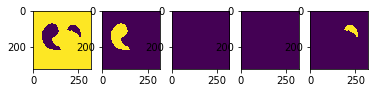

In [10]:
test = mask_1.get_data()[:,:,15]
img = mask_to_channels(test,0,5)
for i in range(0,5):
    plt.subplot(1,5,i+1)
    plt.imshow(img[:,:,i])
plt.show()

In [16]:
def create_data_train(train_ids,name, background = 0):
    
    for idx, train_id in tqdm(enumerate(train_ids)):
        image, mask = read_train_exam(train_id)     
        image = preprocess(image)
        mask = preprocess(mask) 
        print(train_id)
        #transform le mask
        if background:
            #create mask for 5 classess
            mask = mask_to_channels(mask,0,5)[0]
        else:
            mask = mask_to_channels(mask,1,5)[0]            
       
        if idx > 0:
            train_data = np.concatenate((train_data, image),axis=0)
            train_mask = np.concatenate((train_mask, mask),axis=0)
        else:
            train_data = image
            train_mask = mask
    print("Final shape {},{}".format(train_data.shape,train_mask.shape))    
    np.savez_compressed('./dataset/imgs_{}'.format(name), imgs=train_data)
    np.savez_compressed('./dataset/imgs_mask_{}'.format(name), imgs_mask=train_mask)

In [17]:
train_sujets = [1,2,3,5,8]
validation_sujets = [10,13,19]

In [18]:
#dataset training training data
create_data_train(train_sujets,"train_data")

1it [00:00,  3.25it/s]

1
(1, 36, 256, 256, 4)


2it [00:00,  3.11it/s]

2
(1, 26, 256, 256, 4)


3it [00:01,  2.68it/s]

3
(1, 30, 256, 256, 4)
5
(1, 30, 256, 256, 4)


4it [00:01,  2.58it/s]

8
(1, 32, 256, 256, 4)


5it [00:02,  2.28it/s]


Final shape (154, 256, 256, 1),(154, 256, 256, 4)


In [19]:
#dataset training validation data
create_data_train(validation_sujets,"validation_data")

1it [00:00,  3.15it/s]

10
(1, 36, 256, 256, 4)


2it [00:00,  2.92it/s]

13
(1, 30, 256, 256, 4)


3it [00:01,  2.69it/s]

19
(1, 30, 256, 256, 4)
Final shape (96, 256, 256, 1),(96, 256, 256, 4)


### plot images

In [23]:
img = np.load('./dataset/imgs_train_data.npz')['imgs']
img_mask = np.load('./dataset/imgs_mask_train_data.npz')['imgs_mask']

In [44]:
img_mask[:,:,:].shape

(154, 256, 256, 4)

In [25]:
img[:,:,:,0].shape

(154, 256, 256)

In [47]:
#plot random samples from data
def plot_random_images(data,mask):
    index = np.random.choice(range(data.shape[0]),1)[0]
    plt.figure(figsize=(20, 15))
    c = mask.shape[3]
    #image
    plt.subplot(1, c + 1, 1)
    plt.imshow(data[index,:,:,0], cmap='gray', interpolation='nearest')
   
    for i in range(c): 
        plt.subplot(1, c + 1, i+2)
        plt.imshow(mask[index,:,:,i])
    plt.show()

Training data


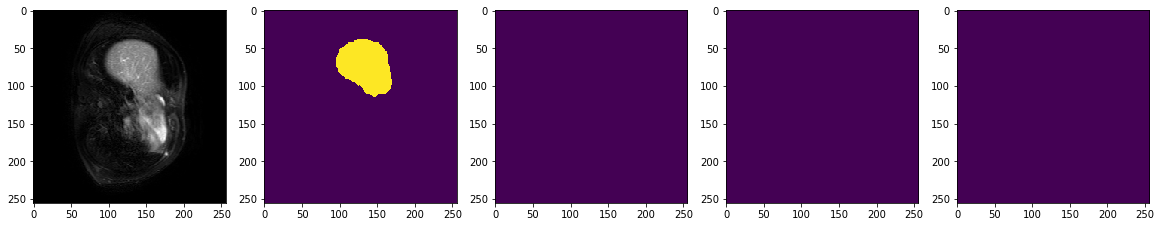

In [48]:
#plot random samples from training data
print("Training data")
plot_random_images(img,img_mask)

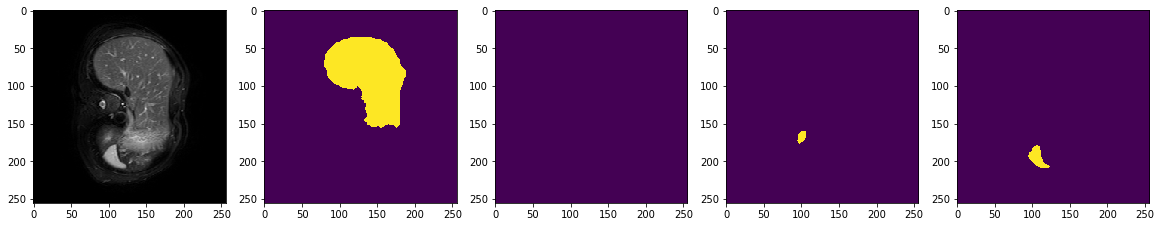

In [51]:
plot_random_images(img,img_mask)

In [52]:
print(np.unique(img))


[0.00000000e+00 1.00974196e-28 1.51461294e-28 ... 1.93000000e+03
 1.93500000e+03 1.97900000e+03]


In [53]:
imgs_train = img.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std

In [54]:
print(np.unique(imgs_train))

[-0.542792   -0.54276794 -0.5427438  ... 11.364295   11.395143
 11.666599  ]


# MODEL

In [1]:
#version tf1
from keras.models import Model
from keras.layers import Input, concatenate,Conv2D, MaxPooling2D, Conv2DTranspose,Dropout
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

Using TensorFlow backend.


In [2]:
img_rows = 256
img_cols = 256

In [3]:
smooth = 1.
#batch 32!
def dice_coef_(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):  
    return -dice_coef_(y_true, y_pred)


In [ ]:
def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(4, (3,3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv9)
    
    model = Model(inputs=[inputs], outputs=[conv10])
    
    return model


# training

In [24]:
# Load slices
x_val = np.load('./dataset/imgs_validation_data.npz')['imgs'].astype('float32')
y_val =np.load('./dataset/imgs_mask_validation_data.npz')['imgs_mask'].astype('float32')
x_train = np.load('./dataset/imgs_train_data.npz')['imgs'].astype('float32')
y_train = np.load('./dataset/imgs_mask_train_data.npz')['imgs_mask'].astype('float32')

# Specify the training configuration (optimizer, loss, metrics)
#checkpointer = ModelCheckpoint(filepath='/weights.hdf5', verbose=1, save_best_only=True)
model = get_unet()

#compile
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef_])
model.summary()
# Train the model by slicing the data into "batches"
# of size "batch_size", and repeatedly iterating over
# the entire dataset for a given number of "epochs"
print('# Fit model on training data')
history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=25,
                    validation_data=(x_val, y_val))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_101 (Conv2D)             (None, 256, 256, 32) 320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_102 (Conv2D)             (None, 256, 256, 32) 9248        conv2d_101[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_102[0][0]                 
__________________________________________________________________________________________________
conv2d_103

Epoch 6/25
154/154 [==============================] - 3s 18ms/step - loss: -0.0245 - dice_coef_: 0.0245 - val_loss: -0.0176 - val_dice_coef_: 0.0176
Epoch 7/25
154/154 [==============================] - 3s 19ms/step - loss: -0.0245 - dice_coef_: 0.0245 - val_loss: -0.0176 - val_dice_coef_: 0.0176
Epoch 8/25
154/154 [==============================] - 3s 18ms/step - loss: -0.0246 - dice_coef_: 0.0246 - val_loss: -0.0176 - val_dice_coef_: 0.0176
Epoch 9/25
154/154 [==============================] - 3s 18ms/step - loss: -0.0247 - dice_coef_: 0.0247 - val_loss: -0.0177 - val_dice_coef_: 0.0177
Epoch 10/25
154/154 [==============================] - 3s 19ms/step - loss: -0.0248 - dice_coef_: 0.0248 - val_loss: -0.0179 - val_dice_coef_: 0.0179
Epoch 11/25
154/154 [==============================] - 3s 18ms/step - loss: -0.0251 - dice_coef_: 0.0251 - val_loss: -0.0182 - val_dice_coef_: 0.0182
Epoch 12/25
154/154 [==============================] - 3s 18ms/step - loss: -0.0258 - dice_coef_: 0.0258

## name = 'model_softmax.h5'

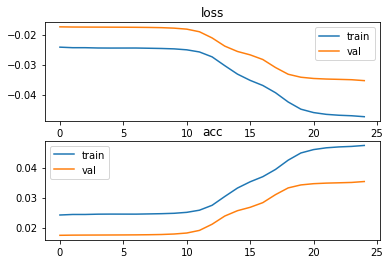

In [25]:
plt.subplot(211)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(history.history['dice_coef_'], label='train')
plt.plot(history.history['val_dice_coef_'], label='val')
plt.title('acc')
plt.legend()

# evaluation

In [28]:
id = 110


test = x_train[id,:,:,:]
y_pred = model.predict(test.reshape(1,256,256,1))

# results

0.0055876924 1.0
6.144612e-28 0.31436852
0.0 0.98527664
0.0 0.5422798


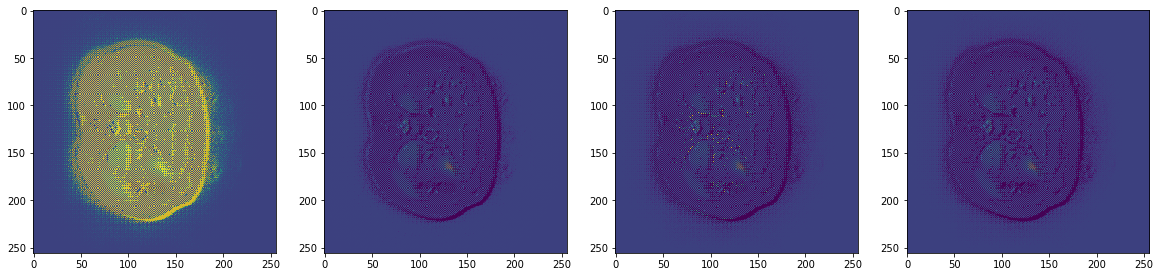

In [29]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.8)
plt.show()

# real

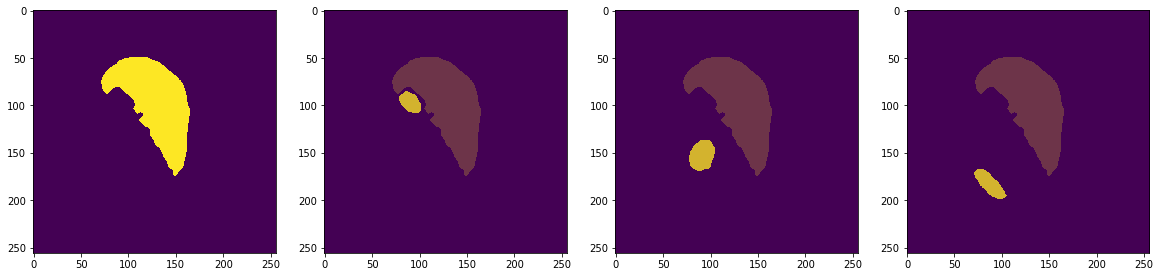

In [14]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = y_train[id,:,:,i]
    plt.imshow(y_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.78)    
plt.show()

# data augmentation

In [35]:
from keras.preprocessing.image import ImageDataGenerator

In [38]:
# Load slices
x_val = np.load('./dataset/imgs_validation_data.npz')['imgs'].astype('float32')
y_val =np.load('./dataset/imgs_mask_validation_data.npz')['imgs_mask'].astype('float32')
x_train = np.load('./dataset/imgs_train_data.npz')['imgs'].astype('float32')
y_train = np.load('./dataset/imgs_mask_train_data.npz')['imgs_mask'].astype('float32')

In [41]:
x_train = np.concatenate([x_val,x_train],axis = 0)
y_train = np.concatenate([y_val,y_train],axis = 0)

In [42]:
x_train.shape

(250, 256, 256, 1)

For example, if your original dataset has 10,000 images and your batch size is 32, then a reasonable value for steps_per_epoch when fitting a model on the augmented data might be ceil(10,000/32), or 313 batches.

In [58]:
# create data generator
datagen = ImageDataGenerator(rotation_range=25)
it = datagen.flow(x_train, y_train)
# Specify the training configuration (optimizer, loss, metrics)
#checkpointer = ModelCheckpoint(filepath='/weights.hdf5', verbose=1, save_best_only=True)
model_a = get_unet()
loss_function = 'categorical_crossentropy'
#compile
model_a.compile(optimizer=Adam(lr=1e-4), loss=['categorical_crossentropy'], metrics=['accuracy'])

# fit model on the augmented dataset
#250/32 =7,8
history_a = model_a.fit_generator(it, steps_per_epoch=8 , epochs=25)

Epoch 1/25
8/8 [==============================] - 6s 737ms/step - loss: 0.1579 - acc: 0.5556
Epoch 2/25
8/8 [==============================] - 4s 468ms/step - loss: 0.0893 - acc: 0.3889
Epoch 3/25
8/8 [==============================] - 4s 474ms/step - loss: 0.0678 - acc: 0.4647
Epoch 4/25
8/8 [==============================] - 4s 476ms/step - loss: 0.0641 - acc: 0.8731
Epoch 5/25
8/8 [==============================] - 4s 479ms/step - loss: 0.0638 - acc: 0.9314
Epoch 6/25
8/8 [==============================] - 4s 480ms/step - loss: 0.0637 - acc: 0.9585
Epoch 7/25
8/8 [==============================] - 4s 480ms/step - loss: 0.0634 - acc: 0.9703
Epoch 8/25
8/8 [==============================] - 4s 482ms/step - loss: 0.0628 - acc: 0.9756
Epoch 9/25
8/8 [==============================] - 4s 479ms/step - loss: 0.0632 - acc: 0.9782
Epoch 10/25
8/8 [==============================] - 4s 480ms/step - loss: 0.0629 - acc: 0.9799
Epoch 11/25
8/8 [==============================] - 4s 482ms/step - lo

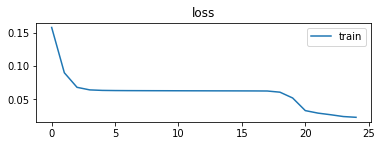

In [59]:
plt.subplot(211)
plt.plot(history_a.history['loss'], label='train')
plt.title('loss')
plt.legend()


https://github.com/hlamba28/UNET-TGS/blob/master/TGS%20UNET.ipynb

In [60]:
id = 110


test = x_train[id,:,:,:]
y_pred = model.predict(test.reshape(1,256,256,1))

# results

0.25107005 1.0
0.0 0.2519388
0.0 0.25688604
0.0 0.31681195


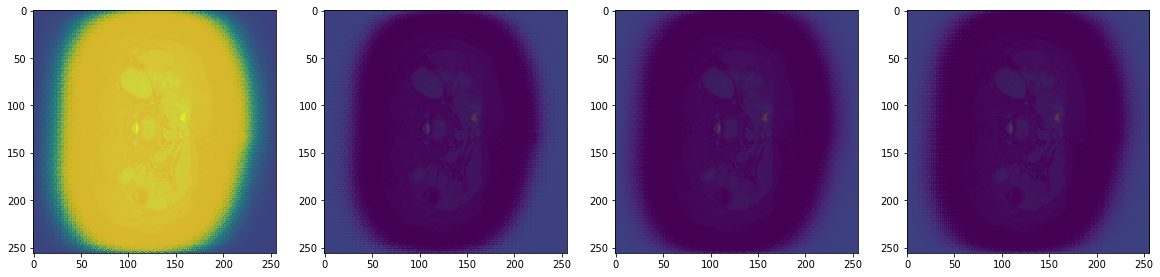

In [61]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(x_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(),slice_.max())
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.8)
plt.show()

# real

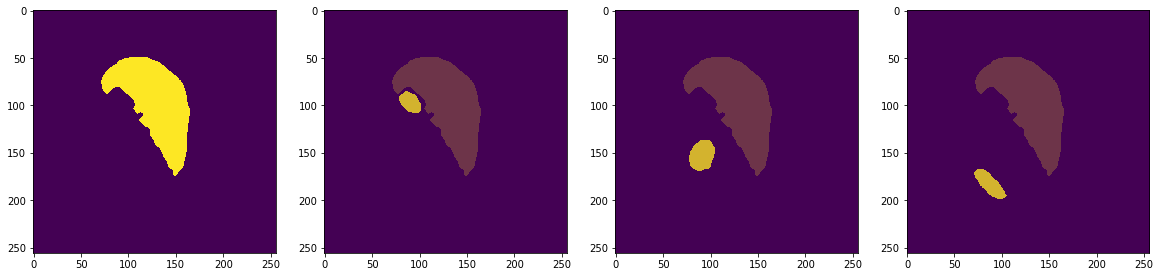

In [14]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = y_train[id,:,:,i]
    plt.imshow(y_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.78)    
plt.show()

> of “training hard enough”.

> When training a deep neural network, our biggest concern is nearly always overfitting — and in order to combat overfitting, we introduce regularization techniques (discussed in Reason #1 above). We apply regularization in the form of:

    Dropout
    L2 weight decay
    Reducing model capacity (i.e., a more shallow model)

>We also tend to be a bit more conservative with our learning rate to ensure our model doesn’t overshoot areas of lower loss in the loss landscape.

In [12]:
def get_unet_reg(dropout = 0.3):
    inputs = Input((img_rows, img_cols, 1))
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(dropout)(pool1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
   
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(dropout)(pool3)
    
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
   

    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    
    
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    
    
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    
    
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
    conv10 = Conv2D(4, (1,1), activation='softmax')(conv9)
    
    loss_function = 'categorical_crossentropy'
    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer=Adam(lr=1e-5), loss=loss_function, metrics=[dice_coef])
    model.summary()
    return model


### Traininng new model

In [13]:
print('Loading and preprocessing train data...')
print('-'*30)
imgs_train, imgs_mask_train = load_train_data()
name = 'model_softmax_reg_propre.h5'

checkpoint = ModelCheckpoint(name, verbose=1, save_best_only=True, save_weights_only=True)
model = get_unet_reg()

imgs_train = imgs_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization
imgs_train -= mean
imgs_train /= std
print("normalize")
np.savez_compressed('scaler',mean=mean,std=std)

results = model.fit(imgs_train, imgs_mask_train, batch_size=32, epochs=40, callbacks=[checkpoint]
                   ,shuffle=True,
              validation_split=0.2)

Loading and preprocessing train data...
------------------------------
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_20[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_21[0][0]                  
______________________________________

Epoch 3/40
200/200 [==============================] - 4s 18ms/step - loss: 0.0634 - dice_coef: 0.2315 - val_loss: 0.0593 - val_dice_coef: 0.3926

Epoch 00003: val_loss improved from 0.05950 to 0.05934, saving model to model_softmax_reg_propre.h5
Epoch 4/40
200/200 [==============================] - 4s 18ms/step - loss: 0.0632 - dice_coef: 0.1697 - val_loss: 0.0592 - val_dice_coef: 0.3911

Epoch 00004: val_loss improved from 0.05934 to 0.05916, saving model to model_softmax_reg_propre.h5
Epoch 5/40
200/200 [==============================] - 4s 18ms/step - loss: 0.0631 - dice_coef: 0.1062 - val_loss: 0.0590 - val_dice_coef: 0.3894

Epoch 00005: val_loss improved from 0.05916 to 0.05897, saving model to model_softmax_reg_propre.h5
Epoch 6/40
200/200 [==============================] - 4s 18ms/step - loss: 0.0629 - dice_coef: 0.2783 - val_loss: 0.0587 - val_dice_coef: 0.3875

Epoch 00006: val_loss improved from 0.05897 to 0.05875, saving model to model_softmax_reg_propre.h5
Epoch 7/40
200/2

200/200 [==============================] - 4s 19ms/step - loss: 0.0246 - dice_coef: 0.6753 - val_loss: 0.0157 - val_dice_coef: 0.8008

Epoch 00037: val_loss did not improve from 0.01548
Epoch 38/40
200/200 [==============================] - 4s 19ms/step - loss: 0.0244 - dice_coef: 0.5028 - val_loss: 0.0156 - val_dice_coef: 0.7997

Epoch 00038: val_loss did not improve from 0.01548
Epoch 39/40
200/200 [==============================] - 4s 19ms/step - loss: 0.0244 - dice_coef: 0.3260 - val_loss: 0.0154 - val_dice_coef: 0.8106

Epoch 00039: val_loss improved from 0.01548 to 0.01536, saving model to model_softmax_reg_propre.h5
Epoch 40/40
200/200 [==============================] - 4s 19ms/step - loss: 0.0241 - dice_coef: 0.8154 - val_loss: 0.0150 - val_dice_coef: 0.8278

Epoch 00040: val_loss improved from 0.01536 to 0.01497, saving model to model_softmax_reg_propre.h5


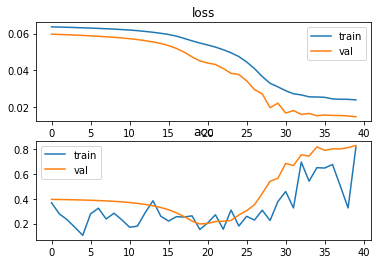

In [15]:
plt.subplot(211)
plt.plot(results.history['loss'], label='train')
plt.plot(results.history['val_loss'], label='val')
plt.title('loss')
plt.legend()

plt.subplot(212)
plt.plot(results.history['dice_coef'], label='train')
plt.plot(results.history['val_dice_coef'], label='val')
plt.title('acc')
plt.legend()


In [8]:
model.load_weights(name)
imgs_train, imgs_mask_train = load_train_data()


In [9]:
id = 110

test = imgs_train[id,:,:,:]
test -= mean
test /= std
y_pred = model.predict(test.reshape(1,256,256,1))

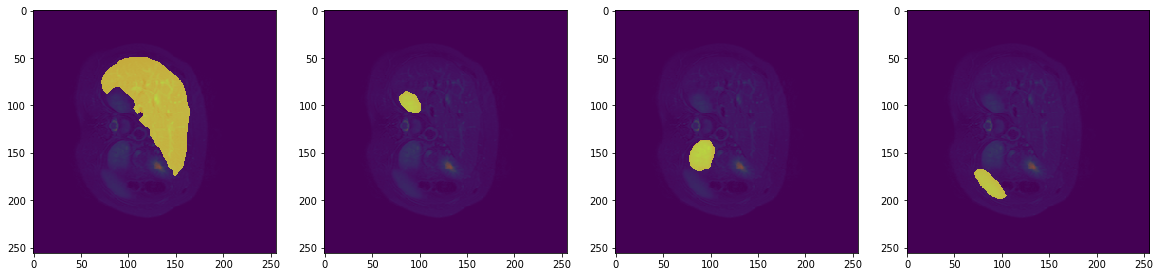

In [10]:
plt.figure(figsize=(20, 15))
for i in range(4):
    plt.subplot(1,4,i+1)
    slice_ = imgs_mask_train[id,:,:,i]
    plt.imshow(imgs_train[id,:,:,0])
    plt.imshow(slice_, alpha=0.7)    
plt.show()

0.1648657 0.99998724
8.540753e-06 0.32173994
3.6098418e-06 0.35842496
1.06076875e-07 0.4193004


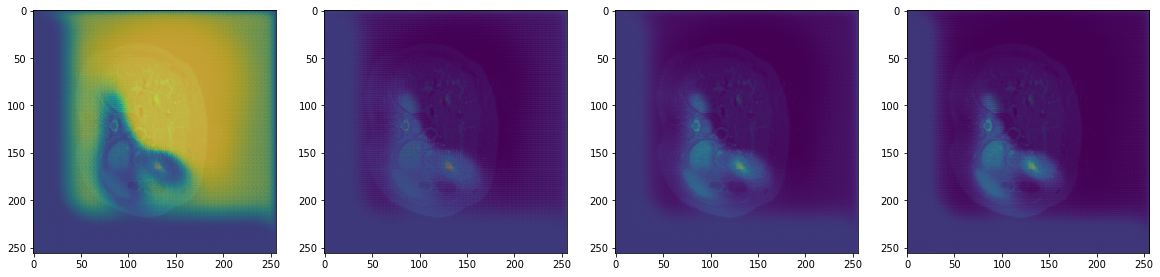

In [11]:
plt.figure(figsize=(20, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.imshow(imgs_train[id,:,:,0])
    slice_ = y_pred[0,:,:,i]
    x = np.sum(y_pred, axis = 3)[0]
    print(slice_.min(), slice_.max())
    m = slice_.mean()
    plt.imshow(slice_,vmin=0,vmax=1, alpha=0.7)
plt.show()